We import the standard Keras library

In [1]:
%%capture
!pip install keras
!pip install tensorflow

In [ ]:
%%capture
import sys, os, re, csv, codecs, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
import pandas as pd

data= pd.read_csv('/kaggle/input/newclass-whystop-reinj/why_stop_annotated.csv')


# fill the empty rows

data['lemmatize_text'] = data['lemmatize_text'].fillna('unknown')
data.columns

In [4]:
import pandas as pd

def simplify_pi_related(data):
    # Define the columns to check for other causes
    columns_to_check = ['trial_no_longer_needed', 'inadequate_study_design_or_study_redesign',
       'efficacy', 'logistics', 'business_or_sponsor_reason',
       'negligence_or_recommandation_of_legalities', 'organizational_issues',
       'safety_ethics_aes','others', 'enrollment_related',
       'pi_related', 'slow_accrual', 'funding_related', 'added_by_error',
       'study_competition', 'covid-19_and_similar_epidemic_related',
       'completed_early_or_truncated_completion']

    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        # Check if 'pi related' is 1 and more than 1 other causes are also 1
        if row['pi_related'] == 1 and sum(row[column] == 1 for column in columns_to_check if column != 'pi related') > 1:
            # Update 'pi related' to 0
            data.at[index, 'pi_related'] = 0
            
    return data

def simplify_enrol_related(data):
    # Define the columns to check for other causes
    columns_to_check = ['trial_no_longer_needed', 'inadequate_study_design_or_study_redesign',
       'efficacy', 'logistics', 'business_or_sponsor_reason',
       'negligence_or_recommandation_of_legalities', 'organizational_issues',
       'safety_ethics_aes', 'others', 'enrollment_related',
       'pi_related', 'slow_accrual', 'funding_related', 'added_by_error',
       'study_competition', 'covid-19_and_similar_epidemic_related',
       'completed_early_or_truncated_completion']

    # Iterate over each row in the DataFrame
    for index, row in data.iterrows():
        # Check if 'pi related' is 1 and more than 1 other causes are also 1
        if row['enrollment_related'] == 1 and sum(row[column] == 1 for column in columns_to_check if column != 'enrollment related') > 2:
            # Update 'pi related' to 0
            data.at[index, 'enrollment_related'] = 0
            
    return data


data = simplify_pi_related(data)
data = simplify_enrol_related(data)

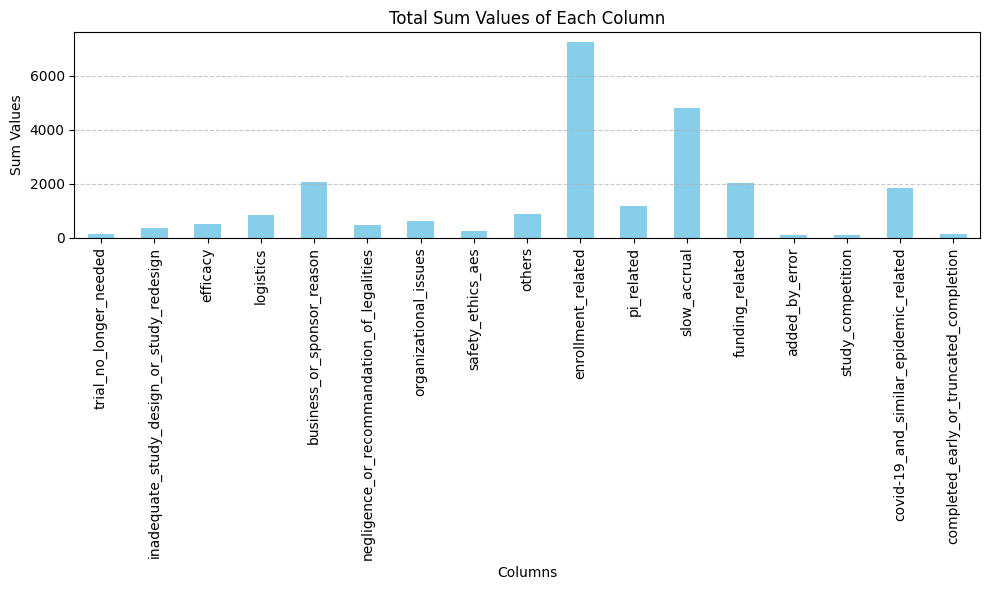

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sum_values(data):
    # Select the columns to plot
    columns_to_plot = ['trial_no_longer_needed', 'inadequate_study_design_or_study_redesign',
       'efficacy', 'logistics', 'business_or_sponsor_reason',
       'negligence_or_recommandation_of_legalities', 'organizational_issues',
       'safety_ethics_aes', 'others', 'enrollment_related',
       'pi_related', 'slow_accrual', 'funding_related', 'added_by_error',
       'study_competition', 'covid-19_and_similar_epidemic_related',
       'completed_early_or_truncated_completion']
    
    # Calculate the sum of each column
    column_sums = data[columns_to_plot].sum()
    
    # Plot the sum values
    plt.figure(figsize=(10, 6))
    column_sums.plot(kind='bar', color='skyblue')
    plt.title('Total Sum Values of Each Column')
    plt.xlabel('Columns')
    plt.ylabel('Sum Values')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming "data" is your DataFrame
plot_sum_values(data)

In [6]:
data.head(5)

,overallstatus,study_type,lemmatize_text,nct_id,raw_text,trial_no_longer_needed,inadequate_study_design_or_study_redesign,efficacy,logistics,business_or_sponsor_reason,...,category,others,enrollment_related,pi_related,slow_accrual,funding_related,added_by_error,study_competition,covid-19_and_similar_epidemic_related,completed_early_or_truncated_completion
0,TERMINATED,OBSERVATIONAL,replace another study,NCT00000105,Replaced by another study.,0,0,0,0,0,...,1.0,0,0,0,0,0,0,1,0,0
1,WITHDRAWN,INTERVENTIONAL,study never open never enrollment patient,NCT00000270,Study never opened; never enrolled participants,0,0,0,0,0,...,1.0,0,1,0,0,0,0,0,0,0
2,TERMINATED,INTERVENTIONAL,original investigator leave institution,NCT00000305,Original P.I. left the institution,0,0,0,0,0,...,1.0,0,0,1,0,0,0,0,0,0
3,TERMINATED,INTERVENTIONAL,unable enrollment adequate number patient,NCT00000309,Unable to recruit adequate number of subjects,0,0,0,0,0,...,1.0,0,1,0,0,0,0,0,0,0
4,WITHDRAWN,INTERVENTIONAL,study never funded,NCT00000340,Study was never funded.,0,0,0,0,0,...,1.0,0,0,0,0,1,0,0,0,0


In [9]:

data["text"] = data['lemmatize_text']

# Split data into train and test
test = data[data['category'].isnull()].copy()  # Select rows where 'category' is null
train = data[data['category'].notnull()].copy()  # Select rows where 'category' is not null

# Drop the 'category' column from train and test dataframes
test.drop(columns=['category'], inplace=True)
train.drop(columns=['category'], inplace=True)

# Reset index
test.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [10]:
print(f"{train.shape} vs {test.shape}")

(9277, 23) vs (15008, 23)


In [12]:
list_classes = ['trial_no_longer_needed', 'inadequate_study_design_or_study_redesign',
       'efficacy', 'logistics', 'business_or_sponsor_reason',
       'negligence_or_recommandation_of_legalities', 'organizational_issues',
       'safety_ethics_aes', 'others', 'enrollment_related',
       'pi_related', 'slow_accrual', 'funding_related', 'added_by_error',
       'study_competition', 'covid-19_and_similar_epidemic_related',
       'completed_early_or_truncated_completion']
y = train[list_classes].values
list_sentences_train = train["text"]
list_sentences_test = test["text"]

In [13]:

words = data['text'].str.split()
# Flatten the list of lists into a single list of words
all_words = [word for sublist in words if isinstance(sublist, list) for word in sublist]
# Count the number of unique words
num_unique_words = len(set(all_words))
# Count the number of unique words
num_unique_words = len(set(all_words))
# Print the result
print("Number of total unique word instances:", num_unique_words)

Number of total unique word instances: 9286


In [14]:
max_features = num_unique_words   ### sometimes +/- 1 is needed
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [16]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

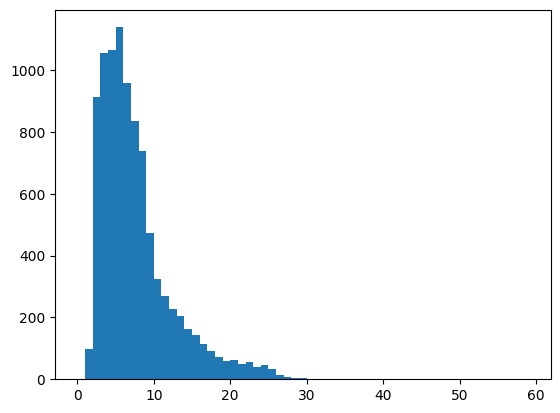

In [17]:
plt.hist(totalNumWords,bins = np.arange(0,60,1))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [18]:
maxlen = max(totalNumWords)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results.
As you probably know, LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, and you would take the final output after X number of recursion. But depending on use cases, you might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer. And this is the case.

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

From the above picture, the unrolled LSTM would give us a set of h0,h1,h2 until the last h.

From the short line of code that defines the LSTM layer, it's easy to miss the required input dimensions. LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

We can make use of the output from the previous embedding layer which outputs a 3-D tensor of (None, 200, 128) into the LSTM layer. What it does is going through the samples, recursively run the LSTM model for 200 times, passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 200, 60), where 60 is the output dimension we have defined.

# GloVe vectorization

In [27]:
from nltk.tokenize import word_tokenize
def create_corpus(df):
    corpus=[]
    for text in df['text']:
        words=[word.lower() for word in word_tokenize(text) if((word.isalpha()==1))]
        corpus.append(words)
    return corpus

In [28]:
corpus=create_corpus(data)

In [29]:
embedding_dict={}
#download via https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation

with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [30]:

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

text_pad=pad_sequences(sequences,maxlen=maxlen,truncating='post',padding='post')
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 9284


In [31]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,200))

for word,i in word_index.items():
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

Strength of Regularization: The value of l2 determines the strength of the L2 regularization penalty. A higher value of l2 leads to stronger regularization, meaning that the model will penalize larger weights more heavily. Conversely, a lower value of l2 results in weaker regularization, allowing the model to have larger weights without being penalized as much.

Impact on Overfitting: Increasing the value of l2 tends to increase the model's resistance to overfitting. By penalizing large weights more heavily, L2 regularization discourages the model from fitting the training data too closely, leading to better generalization performance on unseen data. However, if l2 is too high, it may overly constrain the model and cause underfitting.

Convergence Speed: The choice of l2 can also affect the convergence speed of the training process. Higher values of l2 may slow down the convergence because the model is more constrained by the regularization penalty, requiring more iterations to reach optimal weights. On the other hand, lower values of l2 may allow the model to converge faster but may also increase the risk of overfitting if not properly tuned.

Model Performance: The optimal value of l2 depends on the specific dataset and model architecture. You may need to experiment with different values of l2 through hyperparameter tuning to find the setting that maximizes your model's performance on the validation set.

In [32]:
embedding_matrix.shape

(9285, 200)

In [ ]:
%%time
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.optimizers import Adam
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.regularizers import l2


embed_size = 200
batch_size = 264
epochsx = 500
epochs = epochsx + 1

model = Sequential()

embedding = Embedding(max_features, embed_size, embeddings_initializer=Constant(embedding_matrix),
                       trainable=False)


model.add(embedding)
model.add(SpatialDropout1D(0.5))
#model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))

model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(17, activation='sigmoid'))



optimizer = Adam(learning_rate=2*1e-3)


# Define a callback to save the best model during training based on validation accuracy
checkpoint = ModelCheckpoint('model_{epoch:02d}.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=False,  # Save all models
                             mode='min',
                             period=25, # Save every epoch
                             start_epoch=50)

class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_frequency):
        super(SaveModelCallback, self).__init__()
        self.save_frequency = save_frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 299 and (epoch % self.save_frequency == 0):
            if epoch == epochs:
                self.model.save(f'model_epoch_{epoch+1}.keras')
            else:
                self.model.save(f'model_epoch_{epoch}.keras')

# Define the save frequency (25 epochs in this case)
save_frequency = 25
save_model_callback = SaveModelCallback(save_frequency)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[save_model_callback])

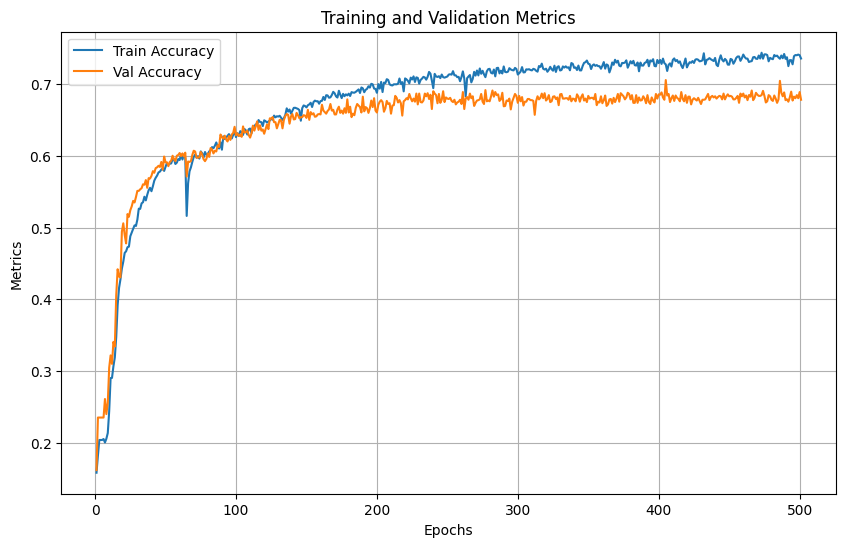

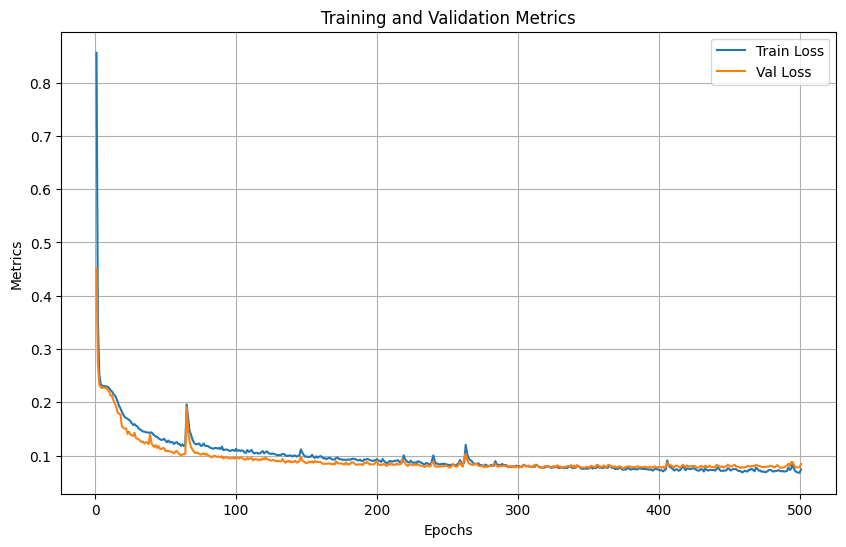

In [34]:
# Extract metrics from history
metrics = {
    'epoch': list(range(1, epochs + 1)),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'train_accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
}


# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot the metrics
plt.figure(figsize=(10, 6))


plt.plot(metrics_df['epoch'], metrics_df['train_accuracy'], label='Train Accuracy')
plt.plot(metrics_df['epoch'], metrics_df['val_accuracy'], label='Val Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()

# Plot the metrics
plt.figure(figsize=(10, 6))

plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss')
plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Val Loss')


plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
from keras.models import load_model
import pandas as pd


best_epoch = ""
best_model = None
best_epoch_val = 1
i = 300
while i <= 500:
    modelepoch = f'model_epoch_{i}.keras'
    print(modelepoch)
    

    
    # Make predictions on the test data using the best model
    epoch_model = load_model(modelepoch)
    predictions = epoch_model.predict(X_te)

    # Assuming test_df is your test dataframe and predictions_df is your predictions dataframe
    predictions_df = pd.DataFrame(predictions, columns=['prediction_{}'.format(i) for i in range(predictions.shape[1])])

    # remove the text col
    testx = test.iloc[:, :-1]
    # Extract the last 16 column names from the test dataframe
    last_16_column_names = testx.columns[-17:]

    # Rename the columns of predictions_df with the last 16 column names
    predictions_df.columns = last_16_column_names
    predictions_df = predictions_df.round(4)
    # Remove the last 16 columns from the test dataframe
    testx = testx.iloc[:, :-17]

    # Concatenate test dataframe and predictions dataframe column-wise
    result_df = pd.concat([testx, predictions_df], axis=1)

    # List of columns to check
    columns_to_check = ['trial_no_longer_needed', 'inadequate_study_design_or_study_redesign',
       'efficacy', 'logistics', 'business_or_sponsor_reason',
       'negligence_or_recommandation_of_legalities', 'organizational_issues',
       'safety_ethics_aes', 'others', 'enrollment_related',
       'pi_related', 'slow_accrual', 'funding_related', 'added_by_error',
       'study_competition', 'covid-19_and_similar_epidemic_related',
       'completed_early_or_truncated_completion']
    # Filter result_df to keep only the rows where at least one value in the specified columns is > 0.5
    filtered_df = result_df[(result_df[columns_to_check] >= 0.5).any(axis=1)]
    unclassified = result_df[(result_df[columns_to_check] < 0.5).any(axis=1)]

    # Add a new column "unclassified" and set the value to 0 for all rows
    filtered_df = filtered_df.assign(unclassified=0)
    unclassified = unclassified.assign(unclassified=1)

    result_df_len = len(result_df)
    filtered_df_len = len(filtered_df)

    # Calculate the result of the expression
    result = (result_df_len - filtered_df_len) / result_df_len
    
    if result < best_epoch_val :
        best_epoch = modelepoch
        best_epoch_val = result
        best_model = epoch_model

    # Print the filtered DataFrame
    print(f"\n{i} epoch: {filtered_df.shape} avec +50% pred sur les {result_df.shape} ou {round(result,2)*100}% d'erreur")
    i += 25

model_epoch_300.keras
469/469 [==============================] - 6s 12ms/step

300 epoch: (9009, 23) avec +50% pred sur les (15008, 22) ou 40.0% d'erreur
model_epoch_325.keras
469/469 [==============================] - 6s 13ms/step

325 epoch: (8870, 23) avec +50% pred sur les (15008, 22) ou 41.0% d'erreur
model_epoch_350.keras
469/469 [==============================] - 6s 13ms/step

350 epoch: (9232, 23) avec +50% pred sur les (15008, 22) ou 38.0% d'erreur
model_epoch_375.keras
469/469 [==============================] - 6s 12ms/step

375 epoch: (9366, 23) avec +50% pred sur les (15008, 22) ou 38.0% d'erreur
model_epoch_400.keras
469/469 [==============================] - 6s 13ms/step

400 epoch: (8849, 23) avec +50% pred sur les (15008, 22) ou 41.0% d'erreur
model_epoch_425.keras
469/469 [==============================] - 6s 13ms/step

425 epoch: (8923, 23) avec +50% pred sur les (15008, 22) ou 41.0% d'erreur
model_epoch_450.keras
469/469 [==============================] - 6s 13ms/ste

In [36]:
### Load the best model
from keras.models import load_model
#best_model = load_model(best_epoch)

# Make predictions on the test data using the best model
predictions = best_model.predict(X_te)
#predictions = model.predict(X_te)

469/469 [==============================] - 6s 12ms/step


In [37]:
import pandas as pd

# Assuming test_df is your test dataframe and predictions_df is your predictions dataframe
predictions_df = pd.DataFrame(predictions, columns=['prediction_{}'.format(i) for i in range(predictions.shape[1])])


# remove the text col
testx = test.iloc[:, :-1]
# Extract the last 16 column names from the test dataframe
last_16_column_names = testx.columns[-17:]

# Rename the columns of predictions_df with the last 16 column names
predictions_df.columns = last_16_column_names
predictions_df = predictions_df.round(4)
# Remove the last 16 columns from the test dataframe
testx = testx.iloc[:, :-17]

# Concatenate test dataframe and predictions dataframe column-wise
result_df = pd.concat([testx, predictions_df], axis=1)

# Print the resulting dataframe
result_df.shape

(15008, 22)

In [38]:
#result_df.to_csv("kaggle/working/withdraw_results.csv",index=False)

In [39]:
# List of columns to check
columns_to_check =['trial_no_longer_needed', 'inadequate_study_design_or_study_redesign',
       'efficacy', 'logistics', 'business_or_sponsor_reason',
       'negligence_or_recommandation_of_legalities', 'organizational_issues',
       'safety_ethics_aes', 'others', 'enrollment_related',
       'pi_related', 'slow_accrual', 'funding_related', 'added_by_error',
       'study_competition', 'covid-19_and_similar_epidemic_related',
       'completed_early_or_truncated_completion']
# Filter result_df to keep only the rows where at least one value in the specified columns is > 0.5
filtered_df = result_df[(result_df[columns_to_check] >= 0.5).any(axis=1)]
unclassified = result_df[(result_df[columns_to_check] < 0.5).any(axis=1)]

# Add a new column "unclassified" and set the value to 0 for all rows
filtered_df = filtered_df.assign(unclassified=0)
unclassified = unclassified.assign(unclassified=1)

result_df_len = len(result_df)
filtered_df_len = len(filtered_df)

# Calculate the result of the expression
result = (result_df_len - filtered_df_len) / result_df_len





# Print the filtered DataFrame
print(f"{filtered_df.shape} avec +50% pred sur les {result_df.shape} ou {round(result,2)*100}% d'erreur")

(9366, 23) avec +50% pred sur les (15008, 22) ou 38.0% d'erreur


In [40]:
import pandas as pd

# Assuming your dataframe is named df

# Step 1: Read your dataframe (replace 'your_data.csv' with your actual file name)
df = result_df

# Step 2: Update values based on the given condition
columns_to_update = ['trial_no_longer_needed', 'inadequate_study_design_or_study_redesign',
       'efficacy', 'logistics', 'business_or_sponsor_reason',
       'negligence_or_recommandation_of_legalities', 'organizational_issues',
       'safety_ethics_aes', 'others', 'enrollment_related',
       'pi_related', 'slow_accrual', 'funding_related', 'added_by_error',
       'study_competition', 'covid-19_and_similar_epidemic_related',
       'completed_early_or_truncated_completion']

# Create a mask for values greater than 0
mask = df[columns_to_update] > 0

# Calculate the sum of >0 values and count of >0 values
sum_of_values = df[columns_to_update][mask].sum(axis=1)
count_of_values = df[columns_to_update][mask].count(axis=1)
# Calculate the average for each row
average_values = sum_of_values / count_of_values

# Create a new column for the calculated average
df['average_column'] = average_values.round(3)


for column in columns_to_update:
    df[column] = df[column].apply(lambda x: 1 if x >= 0.5 else 0)

# Step 3: Add the "unclassified" column and set its value
df['unclassified'] = 0  # Initialize the column with 0

# Iterate over each row to check if none of the specified columns have a value >= 0.5
for index, row in df.iterrows():
    if row[columns_to_update].sum() == 0:  # If none of the columns have a value >= 0.5
        df.at[index, 'unclassified'] = 1  # Set the value of "unclassified" to 1

# Step 4: Create filters to separate the rows
# Rows with only no column (all columns < 0.5)
no_column_filter = df[columns_to_update].sum(axis=1) == 0
no_column_df = df[no_column_filter]

# Rows with only one column = 1
one_column_filter = df[columns_to_update].sum(axis=1) == 1
one_column_df = df[one_column_filter]

# Rows with two columns = 1
two_column_filter = df[columns_to_update].sum(axis=1) == 2
two_column_df = df[two_column_filter]

# Rows with three columns = 1
three_column_filter = df[columns_to_update].sum(axis=1) == 3
three_column_df = df[three_column_filter]

# Rows with three columns = 1
four_column_filter = df[columns_to_update].sum(axis=1) == 4
four_column_df = df[three_column_filter]

# Rows with more than three columns = 1
more_than_three_filter = df[columns_to_update].sum(axis=1) > 4
more_than_three_df = df[more_than_three_filter]

# Now you have separate dataframes based on the specified conditions

print(f" unclassified: {no_column_df.shape}    one cat rows :{one_column_df.shape}    two cat : {two_column_df.shape}     three cat : {three_column_df.shape}  four cat : {four_column_df.shape}    more than 4: {more_than_three_df.shape}")

 unclassified: (5642, 24)    one cat rows :(8798, 24)    two cat : (564, 24)     three cat : (4, 24)  four cat : (4, 24)    more than 4: (0, 24)


In [41]:
train['category'] = 1  # Initialize the column with 0
train['unclassified'] = 0  # Initialize the column with 0
train['average_column'] = 1
df['category'] = None  # Initialize the column with 0
df_final = pd.concat([train,df],ignore_index=True)

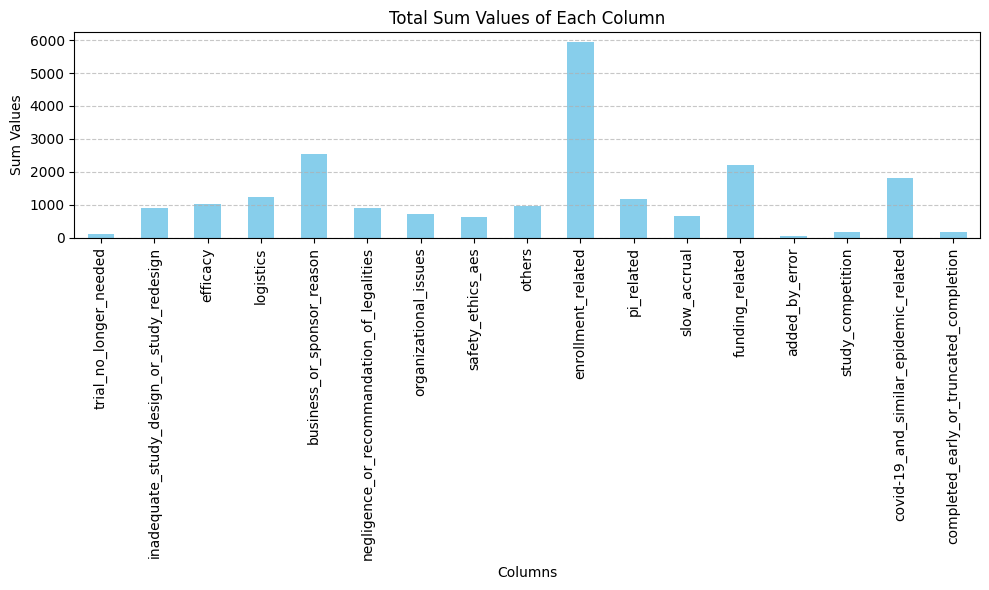

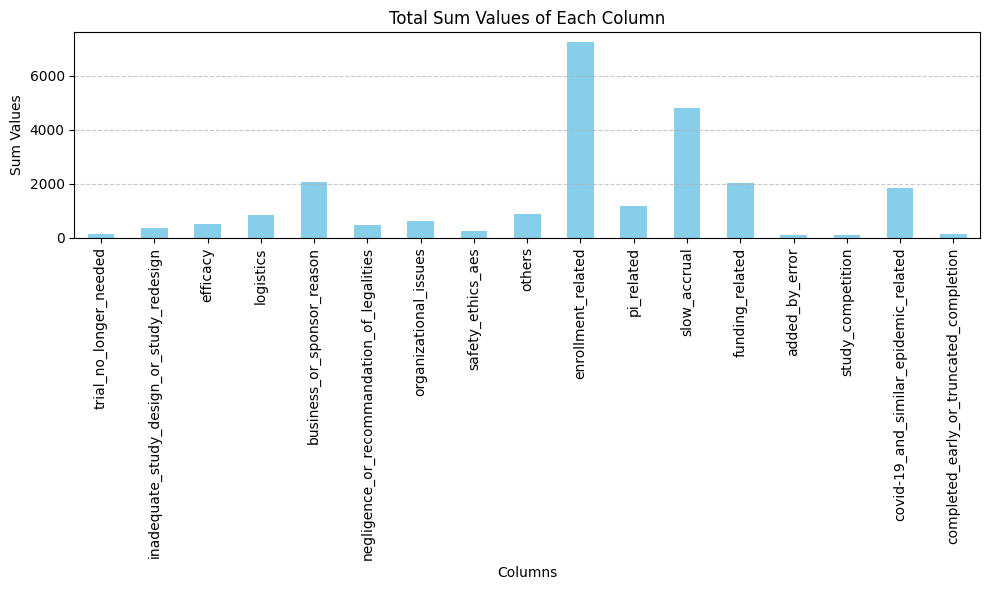

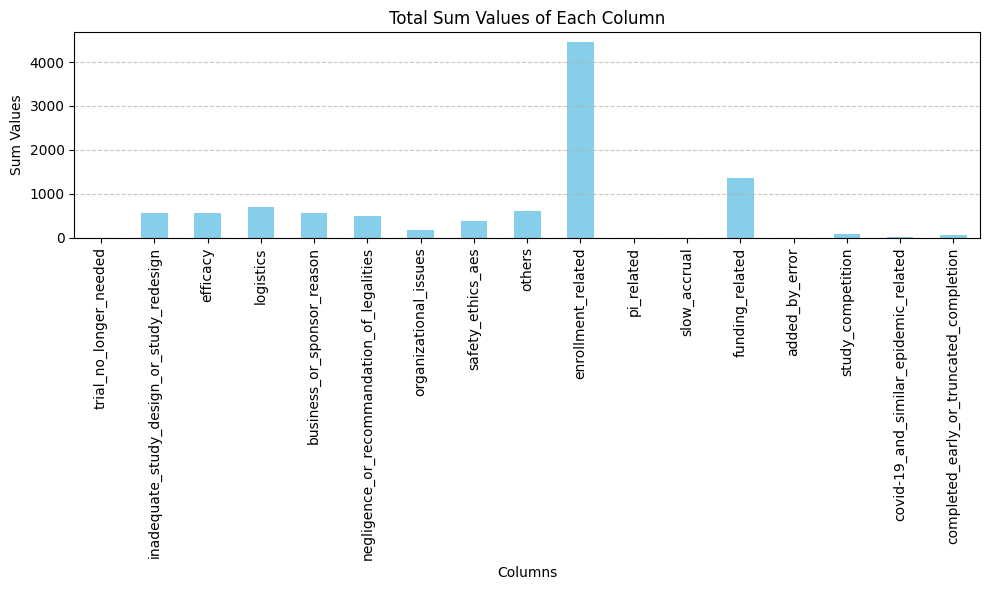

In [42]:
plot_sum_values(df_final)
plot_sum_values(data)
plot_sum_values(result_df)

In [43]:
df

,overallstatus,study_type,lemmatize_text,nct_id,raw_text,trial_no_longer_needed,inadequate_study_design_or_study_redesign,efficacy,logistics,business_or_sponsor_reason,...,pi_related,slow_accrual,funding_related,added_by_error,study_competition,covid-19_and_similar_epidemic_related,completed_early_or_truncated_completion,average_column,unclassified,category
0,TERMINATED,OBSERVATIONAL,analysis identifiable specimen or data complet...,NCT00001978,All analysis with identifiable specimens/data ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0.063,1,None
1,WITHDRAWN,INTERVENTIONAL,study halt prematurely prior enrollment first ...,NCT00003094,"Study was halted prematurely, prior to enrollm...",0,0,0,0,0,...,0,0,0,0,0,0,0,0.067,0,None
2,TERMINATED,INTERVENTIONAL,study enrollment not meet expect goal,NCT00003194,Study enrollment did not meet expected goals,0,0,0,0,0,...,0,0,0,0,0,0,0,0.061,0,None
3,TERMINATED,INTERVENTIONAL,withdrawal due low enrollment,NCT00003508,Withdrawn due to slow enrollment,0,0,0,0,0,...,0,0,0,0,0,0,0,0.062,0,None
4,WITHDRAWN,INTERVENTIONAL,no patient enrollment,NCT00003512,No participants enrolled,0,0,0,0,0,...,0,0,0,0,0,0,0,0.067,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15003,WITHDRAWN,INTERVENTIONAL,standard measure anaesthesia cystoscopy not un...,NCT06301308,The standard measures of anaesthesia in cystos...,0,0,0,0,0,...,0,0,0,0,0,0,0,0.072,0,None
15004,TERMINATED,OBSERVATIONAL,no patient enrollment criterion,NCT06341725,no patients with inclusion criteria,0,0,0,0,0,...,0,0,0,0,0,0,0,0.078,0,None
15005,TERMINATED,INTERVENTIONAL,resectable pancreatic adenocarcinoma neuroendo...,NCT06371716,resectable pancreatic adenocarcinoma and neuro...,0,0,0,0,0,...,0,0,0,0,0,0,0,0.063,1,None
15006,WITHDRAWN,OBSERVATIONAL,research already,NCT06374680,This is because the same research has already ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0.060,0,None


In [44]:
filtered_df.shape

(9366, 23)

In [45]:
df_final.to_csv("newclassification_processed_whystop_results.csv",index=False)

In [46]:
df_final

,overallstatus,study_type,lemmatize_text,nct_id,raw_text,trial_no_longer_needed,inadequate_study_design_or_study_redesign,efficacy,logistics,business_or_sponsor_reason,...,slow_accrual,funding_related,added_by_error,study_competition,covid-19_and_similar_epidemic_related,completed_early_or_truncated_completion,text,category,unclassified,average_column
0,TERMINATED,OBSERVATIONAL,replace another study,NCT00000105,Replaced by another study.,0,0,0,0,0,...,0,0,0,1,0,0,replace another study,1,0,1.000
1,WITHDRAWN,INTERVENTIONAL,study never open never enrollment patient,NCT00000270,Study never opened; never enrolled participants,0,0,0,0,0,...,0,0,0,0,0,0,study never open never enrollment patient,1,0,1.000
2,TERMINATED,INTERVENTIONAL,original investigator leave institution,NCT00000305,Original P.I. left the institution,0,0,0,0,0,...,0,0,0,0,0,0,original investigator leave institution,1,0,1.000
3,TERMINATED,INTERVENTIONAL,unable enrollment adequate number patient,NCT00000309,Unable to recruit adequate number of subjects,0,0,0,0,0,...,0,0,0,0,0,0,unable enrollment adequate number patient,1,0,1.000
4,WITHDRAWN,INTERVENTIONAL,study never funded,NCT00000340,Study was never funded.,0,0,0,0,0,...,0,1,0,0,0,0,study never funded,1,0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24280,WITHDRAWN,INTERVENTIONAL,standard measure anaesthesia cystoscopy not un...,NCT06301308,The standard measures of anaesthesia in cystos...,0,0,0,0,0,...,0,0,0,0,0,0,NaN,None,0,0.072
24281,TERMINATED,OBSERVATIONAL,no patient enrollment criterion,NCT06341725,no patients with inclusion criteria,0,0,0,0,0,...,0,0,0,0,0,0,NaN,None,0,0.078
24282,TERMINATED,INTERVENTIONAL,resectable pancreatic adenocarcinoma neuroendo...,NCT06371716,resectable pancreatic adenocarcinoma and neuro...,0,0,0,0,0,...,0,0,0,0,0,0,NaN,None,1,0.063
24283,WITHDRAWN,OBSERVATIONAL,research already,NCT06374680,This is because the same research has already ...,0,0,0,0,0,...,0,0,0,0,0,0,NaN,None,0,0.060
